# 2022-11-30 Reconstruction

## Last time

* Notes on unstructured meshing workflow
* Finite volume methods for hyperbolic conservation laws
* Riemann solvers for scalar equations
  * Shocks and the Rankine-Hugoniot condition
  * Rarefactions and entropy solutions
  
## Today

* Godunov's Theorem
* Slope reconstruction and limiting
* Hyperbolic systems
  * Rankine-Hugoniot and Riemann Invariants
  * Exact Riemann solvers
  * Approximate Riemann solvers

In [2]:
using LinearAlgebra
using Plots
default(linewidth=3)

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

function testfunc(x)
    max(1 - 4*abs.(x+2/3),
        abs.(x) .< .2,
        (2*abs.(x-2/3) .< .5) * cospi(2*(x-2/3)).^2
    )
end

flux_advection(u) = u
flux_burgers(u) = u^2/2
flux_traffic(u) = u * (1 - u)

riemann_advection(uL, uR) = 1*uL # velocity is +1

function fv_solve1(riemann, u_init, n, tfinal=1)
    h = 2 / n
    x = LinRange(-1+h/2, 1-h/2, n) # cell midpoints (centroids)
    idxL = 1 .+ (n-1:2*n-2) .% n
    idxR = 1 .+ (n+1:2*n) .% n
    function rhs(t, u)
        fluxL = riemann(u[idxL], u)
        fluxR = riemann(u, u[idxR])
        (fluxL - fluxR) / h
    end
    thist, uhist = ode_rk_explicit(rhs, u_init.(x), h=h, tfinal=tfinal)
    x, thist, uhist
end

function riemann_burgers(uL, uR)
    flux = zero(uL)
    for i in 1:length(flux)
        fL = flux_burgers(uL[i])
        fR = flux_burgers(uR[i])
        flux[i] = if uL[i] > uR[i] # shock
            max(fL, fR)
        elseif uL[i] > 0 # rarefaction all to the right
            fL
        elseif uR[i] < 0 # rarefaction all to the left
            fR
        else
            0
        end
    end
    flux
end

function riemann_traffic(uL, uR)
    flux = zero(uL)
    for i in 1:length(flux)
        fL = flux_traffic(uL[i])
        fR = flux_traffic(uR[i])
        flux[i] = if uL[i] < uR[i] # shock
            min(fL, fR)
        elseif uL[i] < .5 # rarefaction all to the right
            fL
        elseif uR[i] > .5 # rarefaction all to the left
            fR
        else
            flux_traffic(.5)
        end
    end
    flux 
end

riemann_traffic (generic function with 1 method)

# Godunov methods (first order accurate)

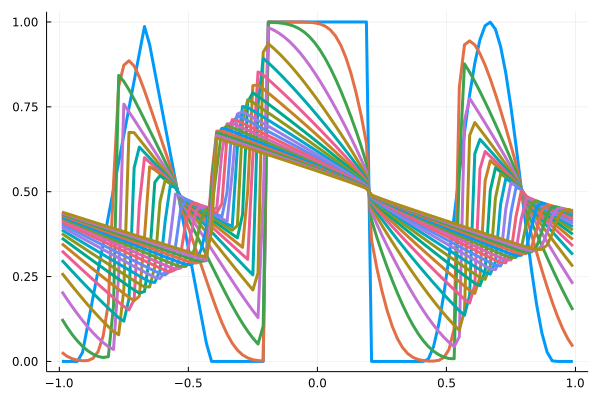

In [13]:
init_func(x) = testfunc(x)
x, thist, uhist = fv_solve1(riemann_traffic, init_func, 100, 2)
plot(x, uhist[:,1:5:end], legend=:none)

## Burgers

* flux $u^2/2$ has speed $u$
* negative values make sense
* satisfies a maximum principle

## Traffic

* flux $u - u^2$ has speed $1 - 2u$
* state must satisfy $u \in [0, 1]$

# Godunov's Theorem (1954)

Linear numerical methods
$$ \dot u_i = \sum_j a_{ij} u_j $$
for solving time-dependent PDE can be at most first order accurate if they are monotone.

For our purposes, monotonicity is equivalent to positivity preservation,
$$ \min_x u(0, x) \ge 0 \quad \Longrightarrow \quad \min_x u(t, 0) \ge 0 .$$

## Discontinuities

A numerical method for representing a discontinuous function on a stationary grid can be no better than first order accurate in the $L^1$ norm,
$$ \lVert u - u^* \rVert_{L^1} = \int \lvert u - u^* \rvert . $$
If we merely sample a discontinuous function, say
$$ u(x) = \begin{cases} 0, & x \le a \\ 1, & x > a \end{cases} $$
onto a grid with element size $\Delta x$ then we will have errors of order 1 on an interval proportional to $\Delta x$.

In light of these two observations, we may still ask for numerical methods that are more than first order accurate for smooth solutions, but those methods must be nonlinear.

# Slope Reconstruction

One method for constructing higher order methods is to use the state in neighboring elements to perform a conservative reconstruction of a piecewise polynomial, then compute numerical fluxes by solving Riemann problems at the interfaces.  If $x_i$ is the center of cell $i$ and $g_i$ is the reconstructed gradient inside cell $i$, our reconstructed solution is
$$ \tilde u_i(x) = u_i + g_i \cdot (x - x_i) . $$
We would like this reconstruction to be monotone in the sense that
$$ \Big(\tilde u_i(x) - \tilde u_j(x) \Big) \Big( u_i - u_j \Big) \ge 0 $$
for any $x$ on the interface between element $i$ and element $j$.

## Question
Is the symmetric slope
$$ \hat g_i = \frac{u_{i+1} - u_{i-1}}{2 \Delta x} $$
monotone?

# Slope limiting



We will determine gradients by "limiting" the above slope using a nonlinear function that reduces to 1 when the solution is smooth.  There are many ways to express limiters and our discussion here roughly follows [Berger, Aftosmis, and Murman (2005)](https://www.nas.nasa.gov/assets/pdf/techreports/2005/nas-05-007.pdf).

![Berger et al, figure 3b, Cell averages](../img/Berger2005-3b-CellAverages.png)

We will express a slope limiter in terms of the ratio
$$ r_i = \frac{u_i - u_{i-1}}{u_{i+1} - u_{i-1}} $$
and use as a gradient,
$$ g_i = \phi(r_i) \frac{u_{i+1} - u_{i-1}}{2 \Delta x} . $$
Our functions $\phi$ will be zero unless $0 < r < 1$ and $\phi(1/2) = 1$.
![Berger et al, figure 3a, Symmetric form of slope limiters](../img/Berger2005-3a-SymSlope.png)
All of these limiters are second order accurate and TVD; those that fall below minmod are not second order accurate and those that are above Barth-Jesperson are not second order accurate, not TVD, or produce artifacts.

# Common limiters

In [3]:
limit_zero(r) = 0
limit_none(r) = 1
limit_minmod(r) = max(min(2*r, 2*(1-r)), 0)
limit_sin(r) = (0 < r && r < 1) * sinpi(r)
limit_vl(r) = max(4*r*(1-r), 0)
limit_bj(r) = max(0, min(1, 4*r, 4*(1-r)))
limiters = [limit_zero limit_none limit_minmod limit_sin limit_vl limit_bj];

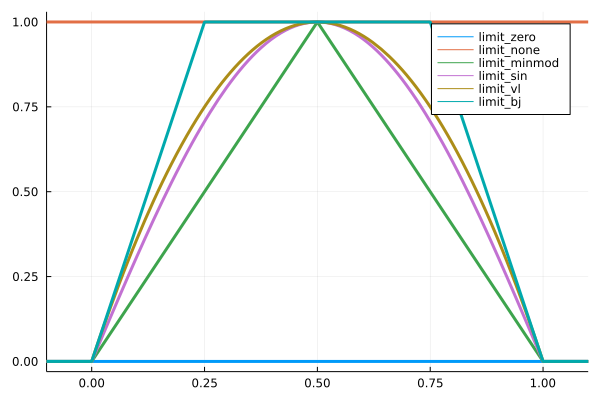

In [4]:
plot(limiters, label=limiters, xlims=(-.1, 1.1))

# A slope-limited solver

In [14]:
function fv_solve2(riemann, u_init, n, tfinal=1, limit=limit_sin)
    h = 2 / n
    x = LinRange(-1+h/2, 1-h/2, n) # cell midpoints (centroids)
    idxL = 1 .+ (n-1:2*n-2) .% n
    idxR = 1 .+ (n+1:2*n) .% n
    function rhs(t, u)
        jump = u[idxR] - u[idxL]
        r = (u - u[idxL]) ./ jump
        r[isnan.(r)] .= 0
        g = limit.(r) .* jump / 2h
        fluxL = riemann(u[idxL] + g[idxL]*h/2, u - g*h/2)
        fluxR = fluxL[idxR]
        (fluxL - fluxR) / h
    end
    thist, uhist = ode_rk_explicit(
        rhs, u_init.(x), h=h, tfinal=tfinal)
    x, thist, uhist
end

fv_solve2 (generic function with 3 methods)

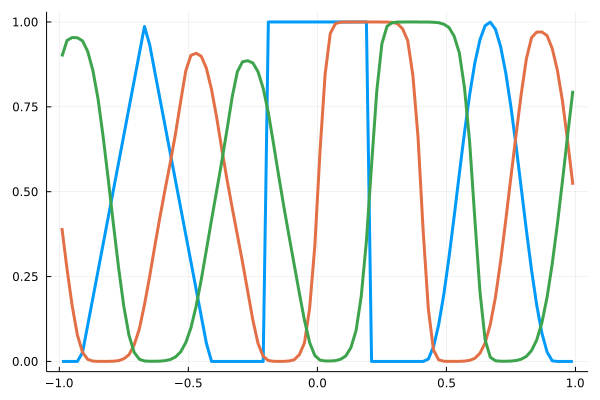

In [20]:
x, thist, uhist = fv_solve2(riemann_advection, testfunc, 100, .5,
    limit_sin)
plot(x, uhist[:,1:10:end], legend=:none)

# Hyperbolic systems

$$ U_t + f(U)_x = 0 $$

## Isentropic gas dynamics

\begin{align} U &= \begin{bmatrix} \rho \\ \rho u \end{bmatrix} & f(U) &= \begin{bmatrix} \rho u \\ \rho u^2 + p \end{bmatrix} \end{align}

| Variable | meaning |
|----------|--------|
| $\rho$ | density |
| $u$    | velocity |
| $\rho u$ | momentum |
| $p$      | pressure |


* Equation of state $p(\rho) = C \rho^\gamma$ with $\gamma = 1.4$ (typical air). 
* "isothermal" gas dynamics: $p(\rho) = c^2 \rho$, wave speed $c$.
* Compute as $ \rho u^2 = \frac{(\rho u)^2}{\rho} .$

## Smooth wave structure

For perturbations of a constant state, systems of equations produce multiple waves with speeds equal to the eigenvalues of the flux Jacobian,
$$ f'(U) = \begin{bmatrix} 0 & 1 \\ -u^2 + c^2 & 2 u \end{bmatrix}. $$
We can compute the eigenvalues and eigenvectors,
$$ f'(U) = W \Lambda W^{-1} $$
as
\begin{align} 
W &= \begin{bmatrix} 1 & 1 \\ u-c & u+c \end{bmatrix} &
\Lambda &= \begin{bmatrix} u-c &  \\ & u+c \end{bmatrix} .
\end{align}

# Riemann problem for systems: shocks

Given states $U_L$ and $U_R$, we will see two waves with some state $U^*$ in between.  There could be two shocks, two rarefactions, or one of each.
The type of wave will determine the condition that must be satisfied to connect $U_L$ to $U_*$ and $U_*$ to $U_R$.

## Left-moving wave

If there is a shock between $U_L$ and $U_*$, the Rankine-Hugoniot condition
$$ s \Delta U = \Delta f $$
will be satisfied along with the entropy condition
$$ \lambda_i(U_L) \ge s \ge \lambda_i(U_*) $$
where $\lambda_i(U)$ is the corresponding eigenvalue of the flux Jacobian $f'(U)$.
The inequality in the entropy condition is strict if the wave is genuinely nonlinear.
For isothermal gas dynamics, the Rankine-Hugoniot condition is
\begin{align}
 (\rho_* - \rho_L) s &= \rho_* u_* - \rho_L u_L \\
 (\rho_* u_* - \rho_L u_L) s &= \Big(\rho_* u_*^2 + c^2 \rho_* \Big) - \Big( \rho_L u_L^2 + c^2 \rho_L \Big)
\end{align}

Solving the first equation for $s$ and substituting into the second, we compute
\begin{split} \frac{(\rho_* u_* - \rho_L u_L)^2}{\rho_* - \rho_L} &= \rho_* u_*^2 - \rho_L u_L^2 + c^2 (\rho_* - \rho_L) \\
 \rho_*^2 u_*^2 - 2 \rho_* \rho_L u_* u_L + \rho_L^2 u_L^2 &= \rho_* (\rho_* - \rho_L) u_*^2 - \rho_L (\rho_* - \rho_L) u_L^2 + c^2 (\rho_* - \rho_L)^2 \\
 \rho_* \rho_L \Big( u_*^2 - 2  u_* u_L + u_L^2 \Big) &= c^2 (\rho_* - \rho_L)^2 \\
 (u_* - u_L)^2 &= c^2 \frac{(\rho_* - \rho_L)^2}{\rho_* \rho_L} \\
 u_* - u_L &= \pm c \frac{\rho_* - \rho_L}{\sqrt{\rho_* \rho_L}}
\end{split}
and will need to use the entropy condition to learn which sign to take.

# Admissible shocks

We need to choose the sign
$$u_* - u_L = \pm c \frac{\rho_* - \rho_L}{\sqrt{\rho_*\rho_L}}$$

The entropy condition requires that
$$ \lambda(U_L) = u_L - c \ge s \ge u_* - c = \lambda(U_*) . $$
Meanwhile, the first Rankine-Hugoniot condition and $\rho > 0$ provides
$$  \rho_L c \le \rho_L (u_L - s) = \rho_* (u_* - s) \le \rho_* c $$
which is to say that $\rho_* \ge \rho_L$ and consequently we take the negative sign,
$$ u_* - u_L = - c\frac{\rho_* - \rho_L}{\sqrt{\rho_* \rho_L}} .$$
## Right-moving wave
The same process for the right wave $\lambda(U) = u + c$ yields a shock when $\rho_* \ge \rho_R$, in which case the velocity jump is
$$ u_R - u_* = - c \frac{\rho_* - \rho_R}{\sqrt{\rho_* \rho_R}} . $$

# Rarefactions

A rarefaction occurs when
$$ \lambda_i(U_L) < \lambda_i(U_R) $$

## Generalized Riemann invariants

$$ \frac{d U^1}{W_i^1} = \frac{d U^2}{W_i^2} = \dotsb $$

(Derivation of this condition is beyond the scope of this class.)

### Isothermal gas dynamics
$$ \frac{d \rho}{1} = \frac{d (\rho u)}{u - c} $$
across the wave $\lambda = u-c$.
We can rearrange to
$$ (u-c) d \rho = \rho d u + u d \rho $$
or
$$ d u + \frac{c}{\rho} d \rho = 0 . $$

Integration yields
$$ u + \int \frac{c}{\rho} d \rho = u + c \log \rho = \text{constant} . $$
So if we have a rarefaction between $U_L$ and $U_*$ then
$$ u_L + c \log \rho_L = u_* + c \log \rho_* . $$
Similarly, for the wave $\lambda = u + c$, a rarefaction between $U_*$ and $U_R$ results in
$$ u_* - c \log \rho_* = u_R - c \log \rho_R . $$
If the rarefaction is sonic, we have $u_0 - c = 0$ for a left rarefaction (or $u_0 + c =0$ for the right) and can compute $\rho_0$ from
$$ u_* -c \log \rho_* = u_0 - c \log \rho_0,$$
via
$$ \rho_0 = \exp\big[(u_0 - u_*)/c + \log \rho_* \big].$$

# Basic algorithm

1. Find $\rho_*$
2. Use entropy condition (for shock speeds)
  * If it's a shock: find $u_*$ using Rankine-Hugoniot
  * If it's a rarefaction: use       generalized Riemann invariant

![](../img/Toro-ShockOrRarefaction-2.19.png)

## First a miracle happens
In general we will need to use a Newton method to solve for the state in the star region.

# Exact Riemann solver for isothermal gas dynamics

In [23]:
function flux_isogas(U, c=1)
    rho = U[1]
    u = U[2] / rho
    [U[1], U[1]*u + c^2*rho]
end

function ujump_isogas(rho_L, rho_R, c=1)
    if rho_R > rho_L # shock
        (rho_L - rho_R) / sqrt(rho_L*rho_R)
    else # rarefaction
        c * (log(rho_L) - log(rho_R))
    end
end

function dujump_isogas(rho_L, drho_L, rho_R, drho_R, c=1)
    if rho_R > rho_L # shock
        ((drho_L - drho_R) / sqrt(rho_L*rho_R)
            - .5*(rho_L - rho_R) * (rho_L*rho_R)^(-3/2) * (drho_L * rho_R + rho_L * drho_R))
    else
        c * (drho_L / rho_L - drho_R / rho_R)
    end
end

dujump_isogas (generic function with 2 methods)

In [24]:
function riemann_isogas(UL, UR, maxit=20)
    rho_L, u_L = UL[1], UL[2]/UL[1]
    rho_R, u_R = UR[1], UR[2]/UR[1]
    rho = .5 * (rho_L + rho_R) # initial guess
    for i in 1:maxit
        f = (ujump_isogas(UL[1], rho)
            + ujump_isogas(rho, UR[1])
            - (UR[2]/UR[1] - UL[2]/UL[1]))
        if norm(resid) < 1e-10
            u = u_L + ujump_isogas(UL[1], rho)
            break
        end
        J = (dujump_isogas(UL[1], 0, rho, 1)
            + dujump_isogas(rho, 1, uR[1], 0))
        delta_rho = -f / J
        while min(rho + delta_rho <= 0)
            delta_rho /= 2 # line search to prevent negative rho
        end
    end
    U0 = resolve_isogas(UL, UR, rho)
    flux_isogas(U0)
end

riemann_isogas (generic function with 2 methods)

# Resolving waves for isothermal gas dynamics

In [25]:
function resolve_isogas(UL, UR, U_star)
    rho_L, u_L = UL[1], UL[2]/UL[1]
    rho_R, u_R = UR[1], UR[2]/UR[1]
    rho, u = U_star[1], U_star[2] / U_star[1]
    if u_L - c < 0 < u - c || u + c < 0 < u_R + c
        # inside left (right) sonic rarefaction
        u0 = sign(u) * c
        rho0 = exp((u0-u)/c + log(rho))
        return [rho0, rho0 * u0]
    elseif ((rho_L >= rho && 0 <= u_L - c) ||
            (rho_L < rho && 0 < rho*u - UL[2]))
        return UL
    elseif ((rho_R >= rho && u_R + c <= 0) ||
            (rho_R < rho && UR[2] - rho*u > 0))
        return UR
    end
    [rho, rho*u]
end

resolve_isogas (generic function with 1 method)

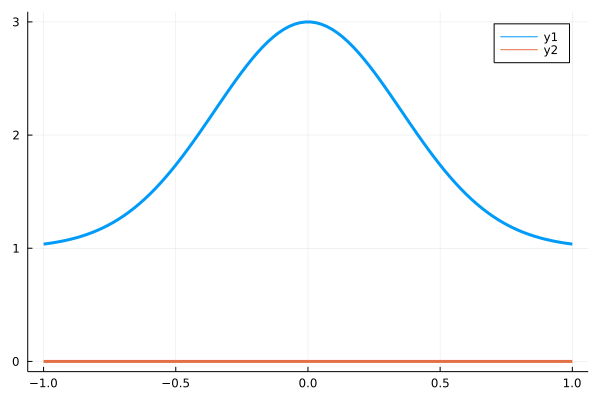

In [42]:
function initial_isogas(x)
    [1 .+ 2 * exp.(-4x .^ 2) 0*x]
end

x = LinRange(-1, 1, 100)
U = initial_isogas(x)
plot(x, U)

# Solver

In [30]:
function fv_solve2system(riemann, u_init, n, tfinal=1, limit=limit_sin)
    h = 2 / n
    x = LinRange(-1+h/2, 1-h/2, n) # cell midpoints (centroids)
    idxL = 1 .+ (n-1:2*n-2) .% n
    idxR = 1 .+ (n+1:2*n) .% n
    U0 = u_init(x)
    m, n = size(U0)
    @show size(U0)
    function rhs(t, U)
        U = reshape(U, m, n)
        jump = u[:,idxR] - u[:,idxL]
        r = (u - u[idxL]) ./ jump
        r[isnan.(r)] .= 0
        g = limit.(r) .* jump / 2h
        fluxL = riemann(u[idxL] + g[idxL]*h/2, u - g*h/2)
        fluxR = fluxL[idxR]
        (fluxL - fluxR) / h
    end
    thist, uhist = ode_rk_explicit(
        rhs, u_init.(x), h=h, tfinal=tfinal)
    x, thist, uhist
end

fv_solve2system (generic function with 3 methods)

In [31]:
x, t_hist, U_hist = fv_solve2system(riemann_isogas, initial_isogas, 100, 0.1)
size(U_hist)

size(U0) = (100,)


LoadError: MethodError: no method matching +(::Vector{Float64}, ::Float64)
For element-wise addition, use broadcasting with dot syntax: array .+ scalar
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  +([91m::T[39m, ::T) where T<:Union{Float16, Float32, Float64} at float.jl:383
[0m  +(::AbstractArray, [91m::StaticArraysCore.StaticArray[39m) at ~/.julia/packages/StaticArrays/6QFsp/src/linalg.jl:13
[0m  ...

# Approximate Riemann solvers

Exact Riemann solvers are
* complicated to implement
* fragile in the sense that small changes to the physics, such as in the equation of state $p(\rho)$, can require changing many conditionals
* the need to solve for $\rho^*$ using a Newton method and then evaluate each case of the wave structure can be expensive.
* An exact Riemann solver has never been implemented for some equations.

## HLL (Harten, Lax, and van Leer)

Assume two shocks with speeds $s_L$ and $s_R$.  These speeds will be estimated and must be at least as fast as the fastest left- and right-traveling waves.  If the wave speeds $s_L$ and $s_R$ are given, we have the Rankine-Hugoniot conditions across both shocks,

\begin{align}
  s_L (U_* - U_L) &= f(U_*) - f(U_L) \\
  s_R (U_R - U_*) &= f(U_R) - f(U_*) .
\end{align}

Adding these together gives
$$s_R U_R - (s_R - s_L) U_* - s_L U_L = f(U_R) - f(U_L)$$
which can be solved for $U_*$ as
$$ U_* = \frac{f(U_L) - f(U_R) - s_L U_L + s_R U_R}{s_R - s_L} . $$
We can save an extra evaluation of the flux by using the Rankine-Hugoniot conditions
$$ f(U_*) = \frac{s_R f(U_L) - s_L f(U_R) + s_L s_R (U_R - U_L)}{s_R - s_L} . $$
### Isothermal gas dynamics
\begin{align} s_L &= \min( u_L - c, u_R - c ) \\
s_R &= \max(u_L + c, u_R + c)
\end{align}

### Rusanov method
Special case $s_L = - s_R$, in which case the wave structure is always subsonic and the flux is simply
$$f(U_*) = \frac 1 2 \Big( f(U_L) + f(U_R) \Big) - \frac s 2 \Big( U_R - U_L \Big) . $$

# Observations on HLL solvers

$$ f(U_*) = \frac{s_R f(U_L) - s_L f(U_R) + s_L s_R (U_R - U_L)}{s_R - s_L} . $$

* The term involving $U_R-U_L$ represents diffusion and will cause entropy to decay (physical entropy is produced).
* If our Riemann problem produces shocks and we have correctly calculated the wave speeds, the HLL solver is exact and produces the minimum diffusion necessary for conservation.
* If the wave speed estimates are slower than reality, the method will be unstable due to CFL.
* If the wave speed estimates are faster than reality, the method will be more diffusive than an exact Riemann solver.